# (Prototype) COVID Dashboard

This is a prototype COVID Dashboard for testing text and graphical display of COVID-related data.

### To do list
1.  Have to add descriptions (for plot titles) and labels for Hospitalization data for time series plotting.
2.  Have to create function to handle IMHE Hospitalization data (since for most of the time series data there exist upper and lower bounds.
3.  (**In Progress**) Modify `html_status()` to somehow logically handle multiple dataframes (for example, passing it John Hopkins, Mobility, and IMHE dataframes should be allowed for state data, allowing printing of summary data from all those datasets.
4.  Consider writing a new version of plotting routine to use BQplot library, which would allow use of widgets framework for easier interactivity.  The problem is it won't overlay multiple datasets (from different dataframes) quite as easily.

In [1]:
# This forces a reload of any external library file if it changes.  
# Useful when developing external libraries since otherwise Jupyter 
# will not re-import any library without restarting the python kernel.

%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from cycler import cycler
import pandas as pd
import datetime
import time
from IPython.core.display import display, HTML
from COVIDlib.collectors import days_since

# Import COVID IO routines from external python libraries
import COVIDlib.data_IO as COVID_IO
import COVIDlib.dashboard_IO as COVID_Dash

# Store the original 10 color sequence of colors used by Matplotlib by default to avoid having
# Seaborn override it
original_cycle = mpl.rcParams['axes.prop_cycle']

# Set up nicer Seaborn style as default
mpl.style.use('seaborn')
mpl.rcParams['axes.prop_cycle']= original_cycle

## Define variables of interest below
data_dir = 'our_data/'    # Data directory for the COVID datafiles

## Define FIPS corresponding to various local areas
ClayFIPS = 27027
CassFIPS = 38017
MNFIPS = 27
NDFIPS = 38

In [3]:
# Load all the dataframes into memory
print("Loading and Preprocessing COVID Dataset ... ", end='')

start= time.perf_counter()
# Retrieve John Hopkins dataframes and add "rates" of deaths/infections
(JH_state_df, JH_cnty_df) = COVID_IO.PtoCDRDataFrames()
JH_state_df = COVID_Dash.cleanJHdata(JH_state_df)
JH_cnty_df = COVID_Dash.cleanJHdata(JH_cnty_df)

# Construct dictionary of FIPS values by placename
FIPSd = COVID_Dash.build_fipsdict(JH_cnty_df, JH_state_df)

# Retrieve Apple Mobility Dataframe
(aapl_cnty_df, aapl_state_df) = COVID_IO.PtoAAPLMobilityDataFrames()
COVID_Dash.cleanAAPLdata(aapl_cnty_df)
COVID_Dash.cleanAAPLdata(aapl_state_df)

# Retrieve Google Mobility Dataframe
(goog_cnty_df, goog_state_df) = COVID_IO.PtoGOOGMobilityDataFrames()

# Retrieve IMHE Dataframes
(summary_df, hospitalization_df) = COVID_IO.PtoIMHEDataFrames()

end= time.perf_counter()

print(f"Done ({end-start:0.2f} sec)")

Loading and Preprocessing COVID Dataset ... Done (1.56 sec)


In [4]:
# Quick experiment to see if we can sum up all the current Infections and Deaths in the US
display(HTML(f'<h1>COVID-19 Information</h1>'))

# Print status reports
states = [FIPSd['United States'], MNFIPS, NDFIPS]
COVID_Dash.html_status(JH_state_df, states, summary_df)
# Added hospital bed summary to html_status via call to html_status_beds
#COVID_Dash.html_status_beds(summary_df, [MNFIPS, NDFIPS])
counties = [ClayFIPS, CassFIPS, FIPSd['Stearns (Minnesota)'], FIPSd['Olmsted (Minnesota)']]
COVID_Dash.html_status(JH_cnty_df, counties)
#Added the predictions not finished

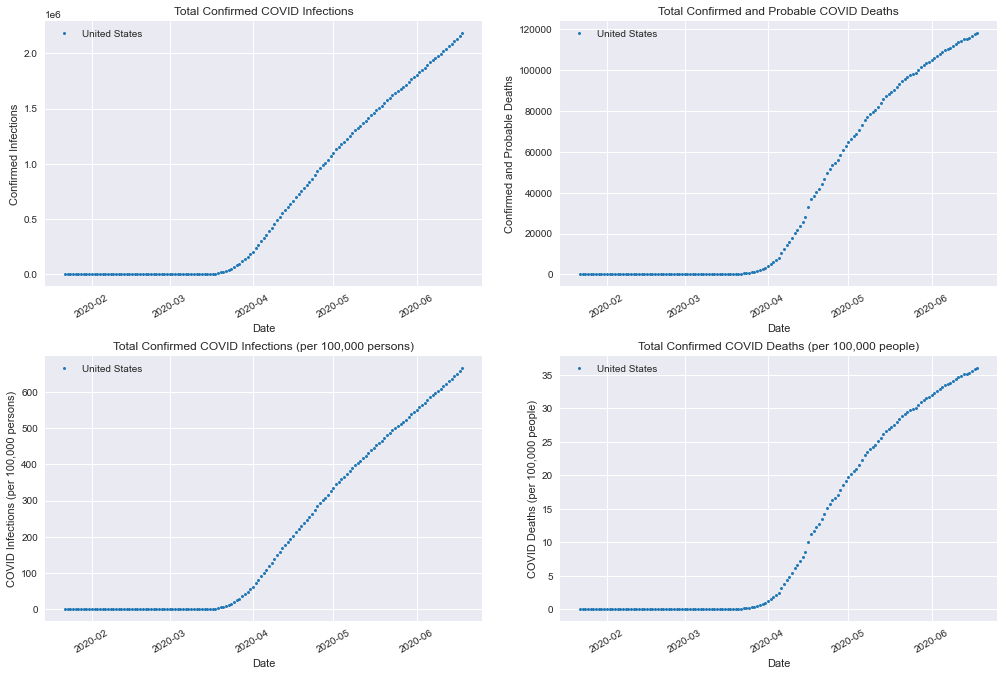

In [5]:
#
# Testing my function for plotting up time-series data (using states)
#
states = [FIPSd['United States']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=5.0)

# Axis numbers here can be viewed as [row, col]
COVID_Dash.ts_plot(JH_state_df, 'Confirmed', states, fig=fig, ax=axs[0, 0]) # Upper Left
COVID_Dash.ts_plot(JH_state_df, 'ConfirmedRate', states, fig=fig, ax=axs[1, 0]) # Lower Left
COVID_Dash.ts_plot(JH_state_df, 'Deaths', states, fig=fig, ax=axs[0, 1]) # Upper Right
COVID_Dash.ts_plot(JH_state_df, 'DeathRate', states, fig=fig, ax=axs[1, 1]) # Lower Right

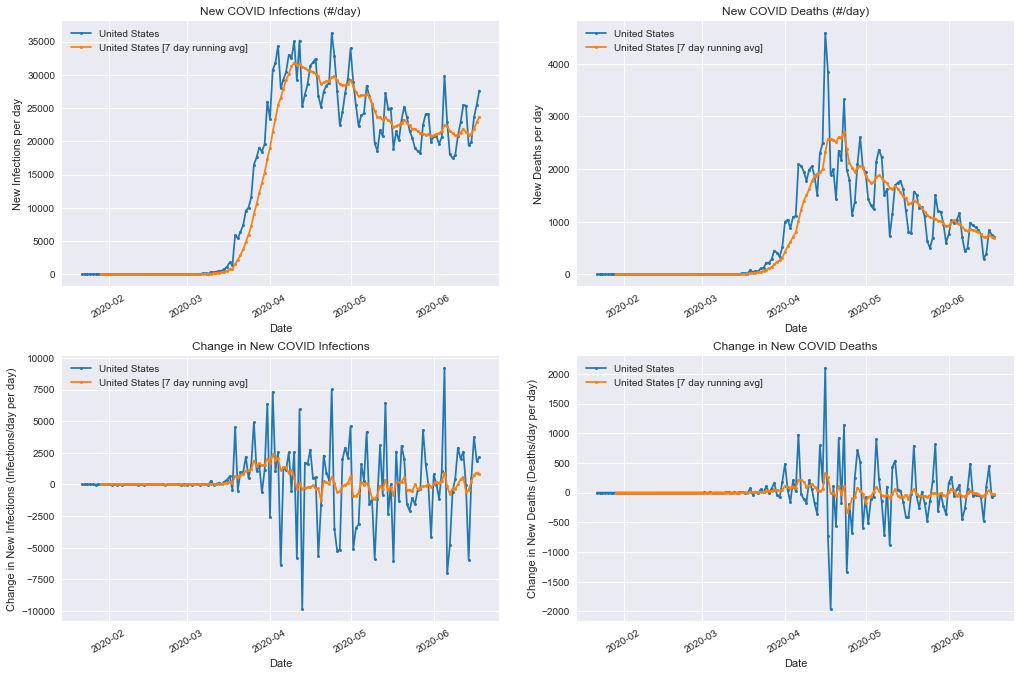

In [6]:
#
# Lets plot up the infection and death rates per day
#
states = [FIPSd['United States']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=5.0)

# Axis numbers here can be viewed as [row, col] for single row
COVID_Dash.ts_plot(JH_state_df, 'dConfirmed', states, connectdots=True, fig=fig, ax=axs[0, 0])
COVID_Dash.ts_plot(JH_state_df, 'dConfirmed', states, connectdots=True, running_avg=7, fig=fig, ax=axs[0, 0])
COVID_Dash.ts_plot(JH_state_df, 'dDeaths', states, connectdots=True, fig=fig, ax=axs[0, 1])
COVID_Dash.ts_plot(JH_state_df, 'dDeaths', states, connectdots=True, running_avg=7, fig=fig, ax=axs[0, 1])
COVID_Dash.ts_plot(JH_state_df, 'd2Confirmed', states, connectdots=True, fig=fig, ax=axs[1, 0])
COVID_Dash.ts_plot(JH_state_df, 'd2Confirmed', states, connectdots=True, running_avg=7, fig=fig, ax=axs[1, 0])
COVID_Dash.ts_plot(JH_state_df, 'd2Deaths', states, connectdots=True, fig=fig, ax=axs[1, 1])
COVID_Dash.ts_plot(JH_state_df, 'd2Deaths', states, connectdots=True, running_avg=7, fig=fig, ax=axs[1, 1])

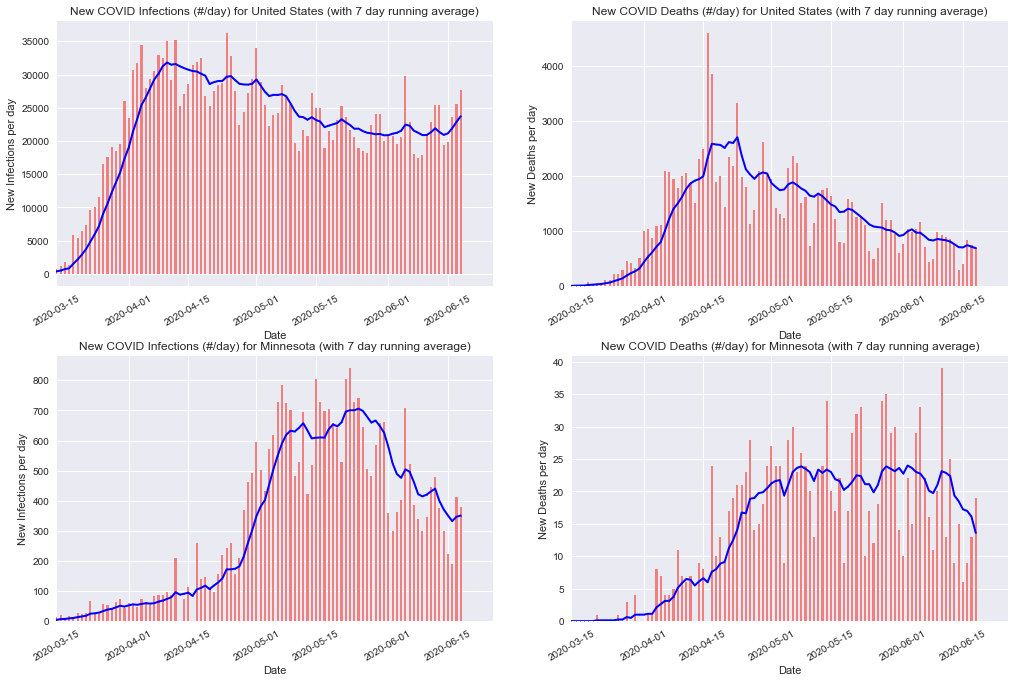

In [7]:
# Try to make a bar graph version of the infections and deaths as well

#
# Lets plot up the infection and death rates per day
#

# Set up a figure of 1 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=5.0)

# Axis numbers here can be viewed as [row, col] for single row
# COVID_Dash.ts_barplot can only handle a SINGLE FIPS number, not a list
COVID_Dash.ts_barplot(JH_state_df, 'dConfirmed', FIPSd['United States'], running_avg=7, fig=fig, ax=axs[0, 0])
COVID_Dash.ts_barplot(JH_state_df, 'dDeaths', FIPSd['United States'], running_avg=7, fig=fig, ax=axs[0, 1])
COVID_Dash.ts_barplot(JH_state_df, 'dConfirmed', FIPSd['Minnesota'], running_avg=7, fig=fig, ax=axs[1, 0])
COVID_Dash.ts_barplot(JH_state_df, 'dDeaths', FIPSd['Minnesota'], running_avg=7, fig=fig, ax=axs[1, 1])

# Adjust the minimum date to be March 15 on all plots
adjust_bounds00 = axs[0, 0].set_xlim( [datetime.date(2020, 3, 15), axs[0, 0].get_xlim()[1]])
adjust_bounds01 = axs[0, 1].set_xlim( [datetime.date(2020, 3, 15), axs[0, 1].get_xlim()[1]])
adjust_bounds10 = axs[1, 0].set_xlim( [datetime.date(2020, 3, 15), axs[1, 0].get_xlim()[1]])
adjust_bounds11 = axs[1, 1].set_xlim( [datetime.date(2020, 3, 15), axs[1, 1].get_xlim()[1]])

## Infections and Deaths for Nearby States

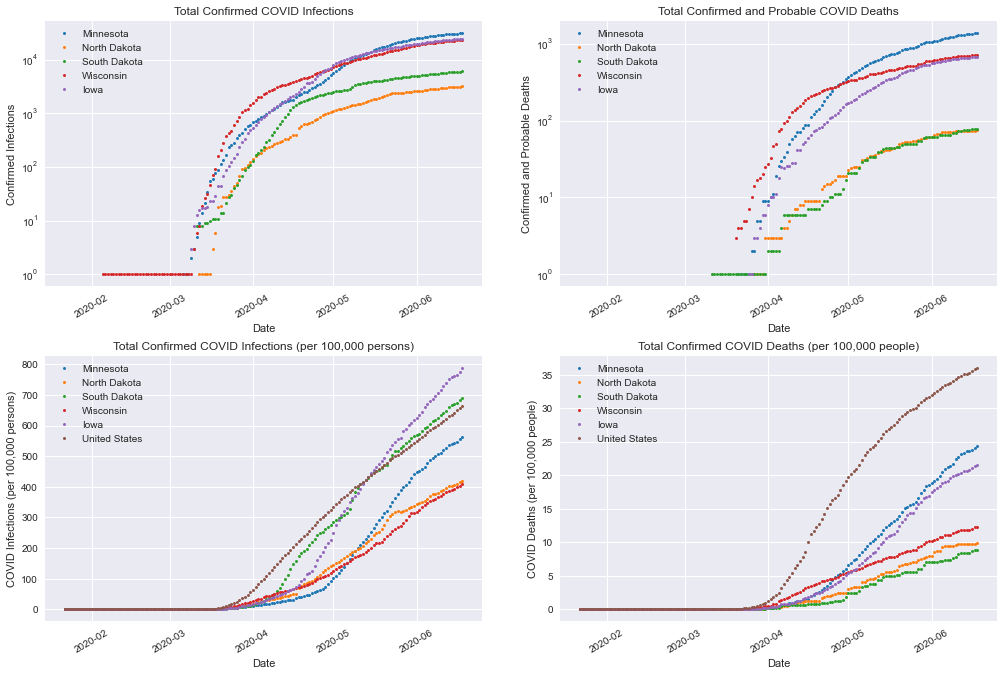

In [8]:
#
# Testing my function for plotting up time-series data (using states)
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
statesNus = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa'], FIPSd['United States']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=5.0)

# Axis numbers here can be viewed as [row, col]
COVID_Dash.ts_plot(JH_state_df, 'Confirmed', states, ylog=True, fig=fig, ax=axs[0, 0]) # Upper Left
COVID_Dash.ts_plot(JH_state_df, 'ConfirmedRate', statesNus, fig=fig, ax=axs[1, 0]) # Lower Left
COVID_Dash.ts_plot(JH_state_df, 'Deaths', states, ylog=True, fig=fig, ax=axs[0, 1]) # Upper Right
COVID_Dash.ts_plot(JH_state_df, 'DeathRate', statesNus, fig=fig, ax=axs[1, 1]) # Lower Right

## Infections and Deaths for Some Selected Counties

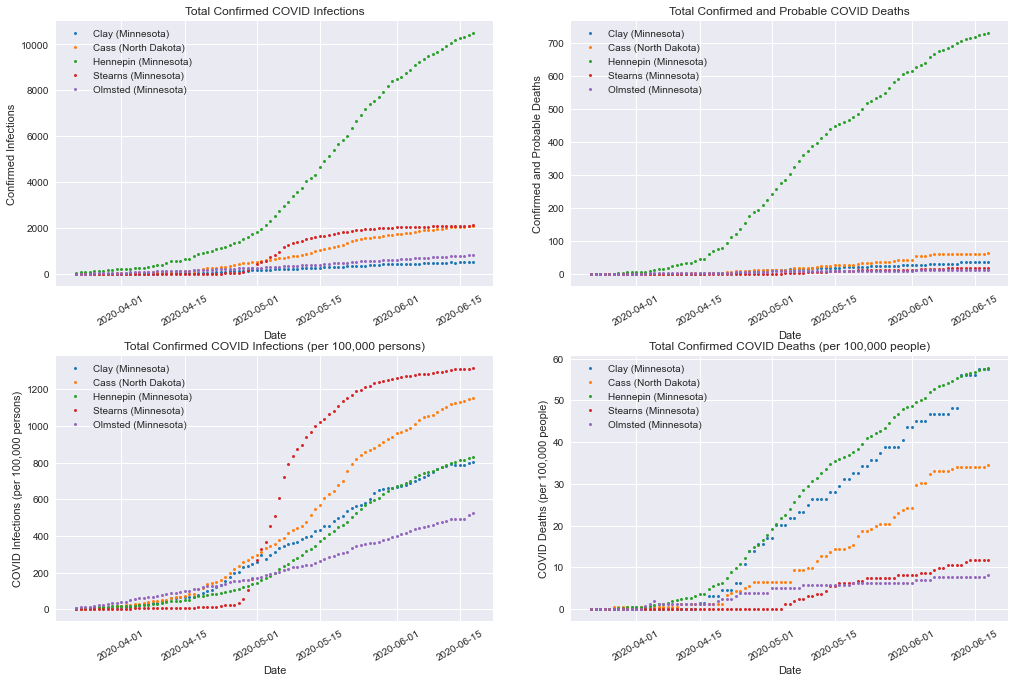

In [9]:
#
# Testing my function for plotting up time-series data (using counties)
#
counties = [ClayFIPS, CassFIPS, FIPSd['Hennepin (Minnesota)'], FIPSd['Stearns (Minnesota)'], FIPSd['Olmsted (Minnesota)']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=5.0)

# Axis numbers here can be viewed as [row, col]
COVID_Dash.ts_plot(JH_cnty_df, 'Confirmed', counties, fig=fig, ax=axs[0, 0]) # Upper Left
COVID_Dash.ts_plot(JH_cnty_df, 'ConfirmedRate', counties, fig=fig, ax=axs[1, 0]) # Lower Left
COVID_Dash.ts_plot(JH_cnty_df, 'Deaths', counties, fig=fig, ax=axs[0, 1]) # Upper Right
COVID_Dash.ts_plot(JH_cnty_df, 'DeathRate', counties, fig=fig, ax=axs[1, 1]) # Lower Right
    

## Infections and Deaths for a Mixture of States and Counties

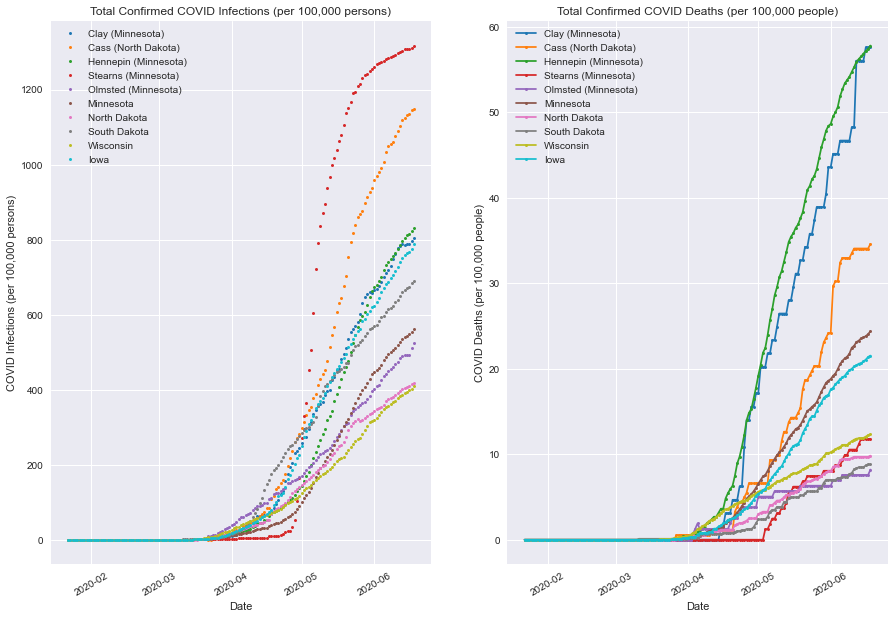

In [10]:
#
# Producing a plot of 2 plots next to each other, this makes the axis argument returned by subplots a 1-D list
# This example also shows how we can overlay state and county data when appropriate, just run the time-series function
# on the same axis element and it will update it instead of erasing it.
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
counties = [ClayFIPS, CassFIPS, FIPSd['Hennepin (Minnesota)'], FIPSd['Stearns (Minnesota)'], FIPSd['Olmsted (Minnesota)']]

# Set up a single figure
fig, axs = plt.subplots(1, 2, figsize=(15,10))

COVID_Dash.ts_plot(JH_cnty_df, 'ConfirmedRate', counties, fig=fig, ax=axs[0]) # Counties
COVID_Dash.ts_plot(JH_state_df, 'ConfirmedRate', states, fig=fig, ax=axs[0]) # States
COVID_Dash.ts_plot(JH_cnty_df, 'DeathRate', counties, connectdots=True, fig=fig, ax=axs[1]) # Counties
COVID_Dash.ts_plot(JH_state_df, 'DeathRate', states, connectdots=True, fig=fig, ax=axs[1]) # States

# You could execute a command like this to save the image to a file (it automatically determines file
# format based on the suffix).  
# plt.savefig("COVID_data.png")

## People Tested in Nearby States

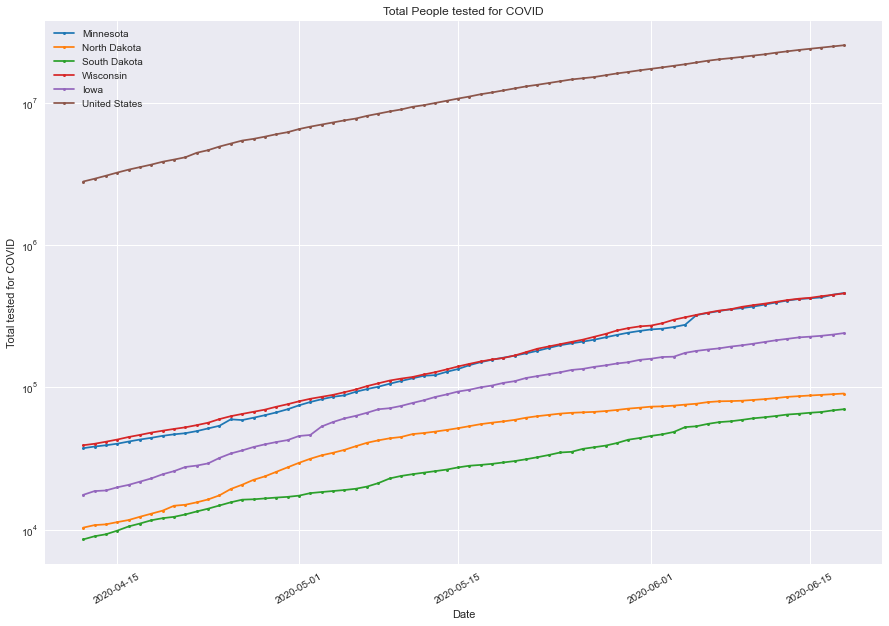

In [11]:
#
# Producing a single plot makes the axis argument returned by subplots a scalar, also using
# logarithmic axis by adjusting the plot after the fact
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa'], FIPSd['United States']]

# Set up a single figure
fig, axs = plt.subplots(1, 1, figsize=(15,10))

COVID_Dash.ts_plot(JH_state_df, 'People_Tested', states, connectdots=True, ylog=True,  fig=fig, ax=axs) # States

## Infection and Death  Per Day

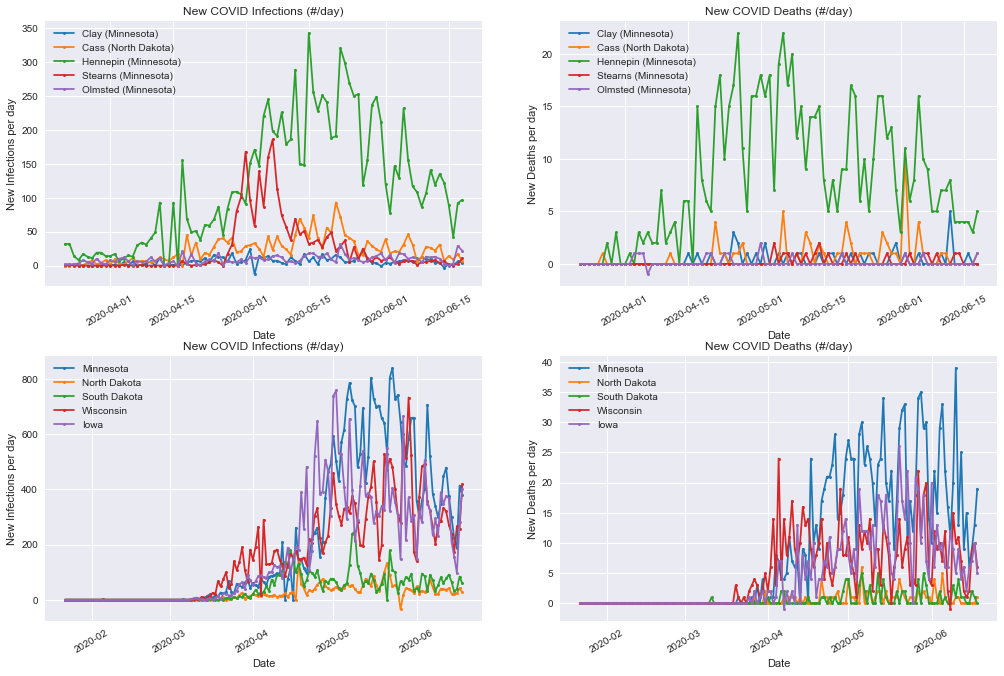

In [12]:
#
# Lets plot up the infection and death rates per day
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
counties = [ClayFIPS, CassFIPS, FIPSd['Hennepin (Minnesota)'], FIPSd['Stearns (Minnesota)'], FIPSd['Olmsted (Minnesota)']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=5.0)

# Axis numbers here can be viewed as [row, col]
COVID_Dash.ts_plot(JH_cnty_df, 'dConfirmed', counties, connectdots=True, fig=fig, ax=axs[0, 0]) # Upper Left
COVID_Dash.ts_plot(JH_state_df, 'dConfirmed', states, connectdots=True, fig=fig, ax=axs[1, 0]) # Lower Left
COVID_Dash.ts_plot(JH_cnty_df, 'dDeaths', counties, connectdots=True, fig=fig, ax=axs[0, 1]) # Upper Right
COVID_Dash.ts_plot(JH_state_df, 'dDeaths', states, connectdots=True, fig=fig, ax=axs[1, 1]) # Lower Right

## Change in Rate of Infections and Deaths Per Day for Selected Counties

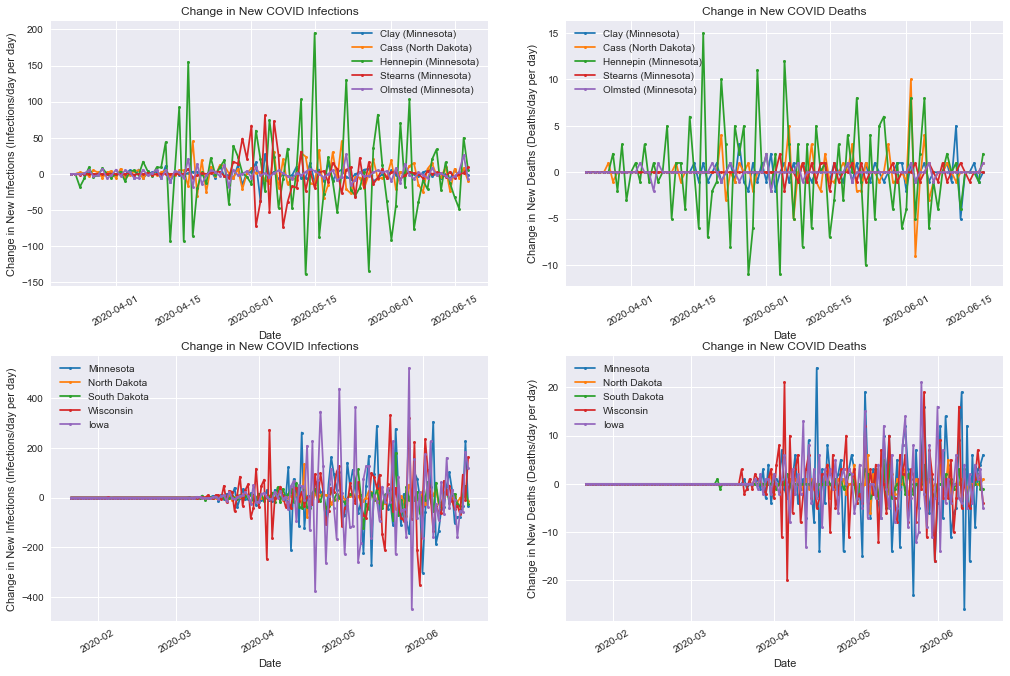

In [13]:
#
# Lets plot up the changes in those infection and death rates per day (This shows that this data likely needs to be smoothed
# to see trends).mobiiliuty
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
counties = [ClayFIPS, CassFIPS, FIPSd['Hennepin (Minnesota)'], FIPSd['Stearns (Minnesota)'], FIPSd['Olmsted (Minnesota)']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=5.0)

# Axis numbers here can be viewed as [row, col]
COVID_Dash.ts_plot(JH_cnty_df, 'd2Confirmed', counties, connectdots=True, fig=fig, ax=axs[0, 0]) # Upper Left
COVID_Dash.ts_plot(JH_state_df, 'd2Confirmed', states, connectdots=True, fig=fig, ax=axs[1, 0]) # Lower Left
COVID_Dash.ts_plot(JH_cnty_df, 'd2Deaths', counties, connectdots=True, fig=fig, ax=axs[0, 1]) # Upper Right
COVID_Dash.ts_plot(JH_state_df, 'd2Deaths', states, connectdots=True, fig=fig, ax=axs[1, 1]) # Lower Right

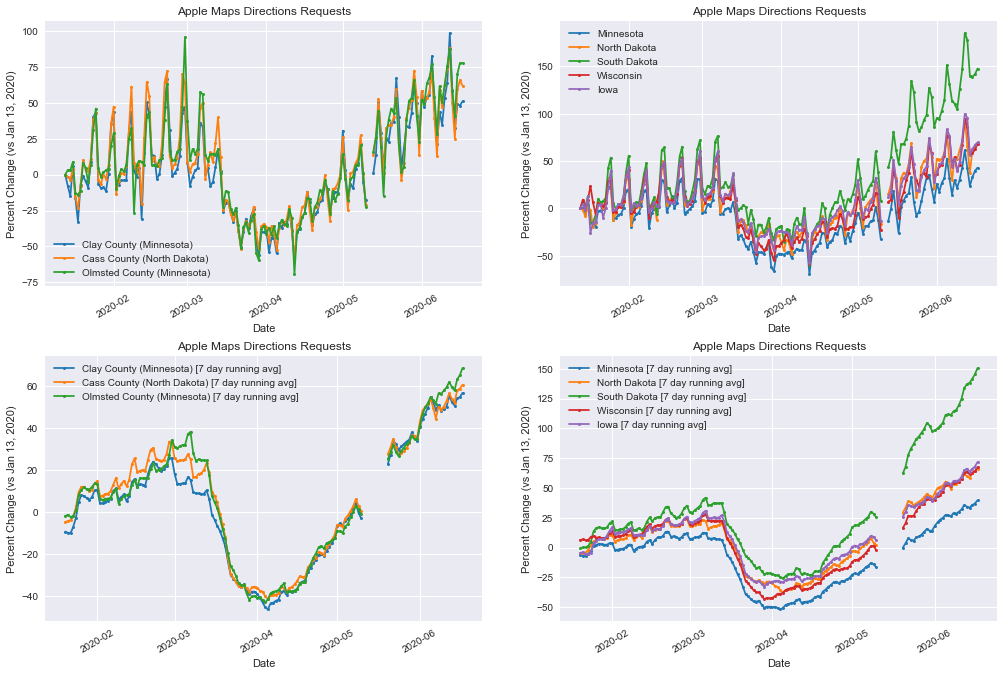

In [14]:
#
# Testing my function for plotting up time-series mobility data
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
counties = [ClayFIPS, CassFIPS, FIPSd['Olmsted (Minnesota)']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=5.0)

# Axis numbers here can be viewed as [row, col]
COVID_Dash.ts_plot(aapl_cnty_df, 'driving_mobility_Percent', counties, connectdots=True, fig=fig, ax=axs[0, 0])
COVID_Dash.ts_plot(aapl_state_df, 'driving_mobility_Percent', states, connectdots=True, fig=fig, ax=axs[0, 1]) 
COVID_Dash.ts_plot(aapl_cnty_df, 'driving_mobility_Percent', counties, running_avg=7, connectdots=True, fig=fig, ax=axs[1, 0])
COVID_Dash.ts_plot(aapl_state_df, 'driving_mobility_Percent', states, running_avg=7, connectdots=True, fig=fig, ax=axs[1, 1]) 

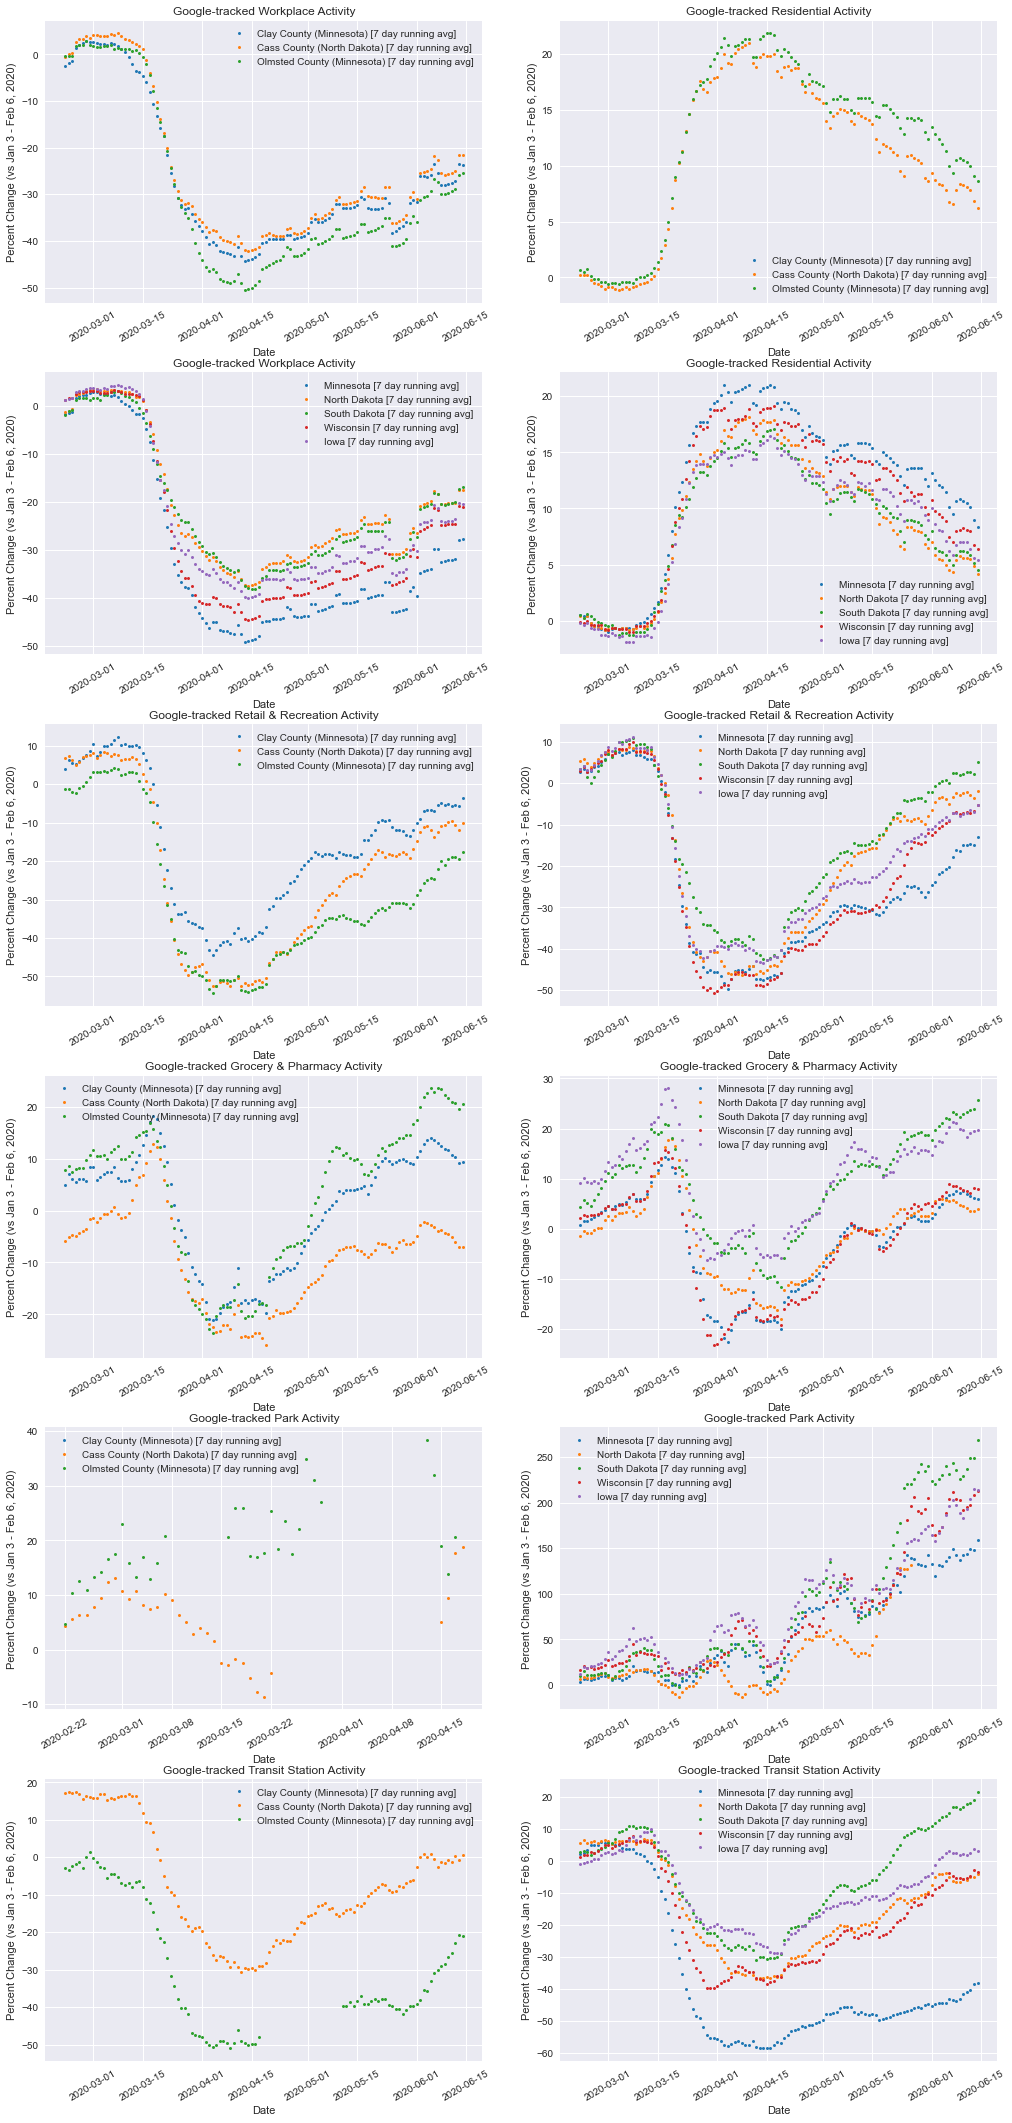

In [15]:
#
# Again, testing my function for plotting up time-series mobility data 
# (this time using running averages to smooth the data).
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
counties = [ClayFIPS, CassFIPS, FIPSd['Olmsted (Minnesota)']]

# Set up a figure of 6 x 2 plots
fig, axs = plt.subplots(6, 2, figsize=(15,30))
fig.tight_layout(pad=5.0)

# Axis numbers here can be viewed as [row, col] 
COVID_Dash.ts_plot(goog_cnty_df, 'workplace_Percent', counties, running_avg=7, fig=fig, ax=axs[0,0])
COVID_Dash.ts_plot(goog_state_df, 'workplace_Percent', states, running_avg=7, fig=fig, ax=axs[1, 0]) 
COVID_Dash.ts_plot(goog_cnty_df, 'residential_Percent', counties, running_avg=7, fig=fig, ax=axs[0, 1])
COVID_Dash.ts_plot(goog_state_df, 'residential_Percent', states, running_avg=7, fig=fig, ax=axs[1, 1]) 
COVID_Dash.ts_plot(goog_cnty_df, 'retail_recreation_Percent', counties, running_avg=7, fig=fig, ax=axs[2, 0])
COVID_Dash.ts_plot(goog_state_df, 'retail_recreation_Percent', states, running_avg=7, fig=fig, ax=axs[2, 1]) 
COVID_Dash.ts_plot(goog_cnty_df, 'grocery_pharm_Percent', counties, running_avg=7, fig=fig, ax=axs[3, 0])
COVID_Dash.ts_plot(goog_state_df, 'grocery_pharm_Percent', states, running_avg=7, fig=fig, ax=axs[3, 1]) 
COVID_Dash.ts_plot(goog_cnty_df, 'parks_Percent', counties, running_avg=7, fig=fig, ax=axs[4, 0])
COVID_Dash.ts_plot(goog_state_df, 'parks_Percent', states, running_avg=7, fig=fig, ax=axs[4, 1]) 
COVID_Dash.ts_plot(goog_cnty_df, 'transit_stations_Percent', counties, running_avg=7, fig=fig, ax=axs[5, 0])
COVID_Dash.ts_plot(goog_state_df, 'transit_stations_Percent', states, running_avg=7, fig=fig, ax=axs[5, 1]) 

## Hospitaliziation Data Current Values & Predictions

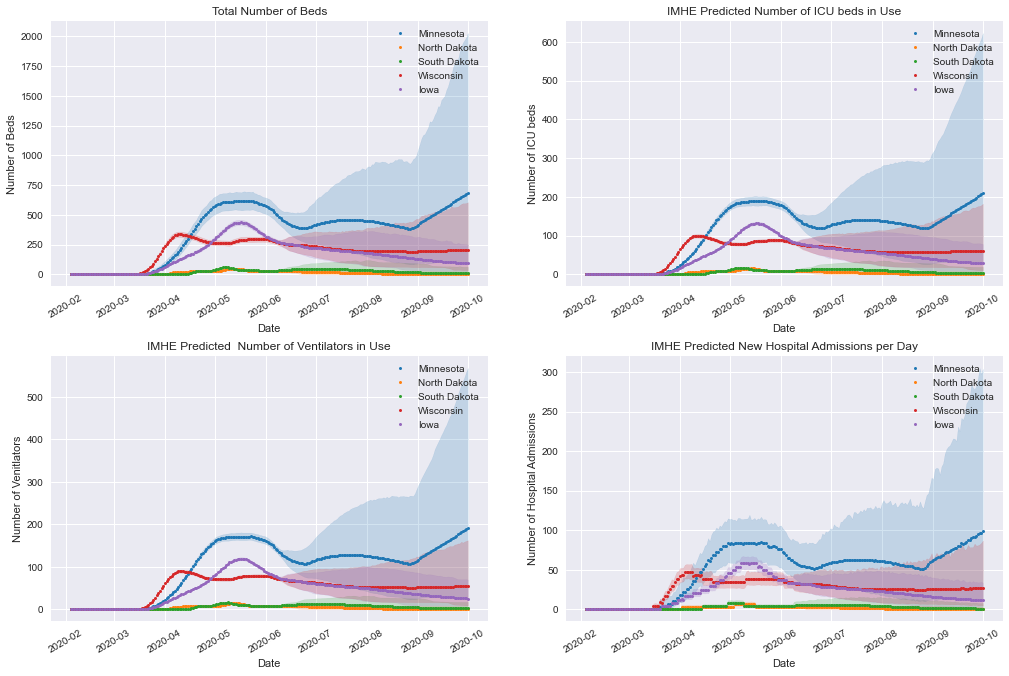

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=5.0)

# Axis numbers here can be viewed as [row, col]
COVID_Dash.ts_plot_Hos(hospitalization_df, 'allbed_mean', states, fig=fig, ax=axs[0, 0]) # Upper Left
COVID_Dash.ts_plot_Hos(hospitalization_df, 'InvVen_mean', states, fig=fig, ax=axs[1, 0]) # Lower Left
COVID_Dash.ts_plot_Hos(hospitalization_df, 'ICUbed_mean', states, fig=fig, ax=axs[0, 1]) # Upper Right
COVID_Dash.ts_plot_Hos(hospitalization_df, 'admis_mean', states, fig=fig, ax=axs[1, 1]) # Lower Right